In [229]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


In [230]:
def plot_area_vs_aa_nums(df, aa_col, area_col, title):
    model = LinearRegression(fit_intercept=False)
    X =np.sqrt(df[aa_col])
    X = X.values.reshape(-1, 1)
    y = df[area_col]
    model.fit(X, y)
    m = model.coef_[0]
    plt.plot(X.flatten(), m*X.flatten(), "-", c="r")
    plt.text(20, 80, "y = {:.2f}x".format(m), fontsize=12, color="r")
    plt.scatter(np.sqrt(df[aa_col]), df[area_col], label="Monomer", marker=".")
    plt.xlabel("sqrt(aa_nums)")
    plt.ylabel(area_col)
    plt.title(title)
    return model

In [231]:
data_path = "../artifacts/inner_membrane_curated.csv"

In [232]:
df = pd.read_csv(data_path)
area_col = ["area_full", "area_trans"]
df.loc[:, area_col] = df[area_col].apply(lambda x: x/100) # convert to nm^2


In [233]:
df_monomer_complex_map = df[["id", "complex"]]
df_monomer_complex_map.to_csv("../artifacts/monomer_complex_map.csv", index=False)

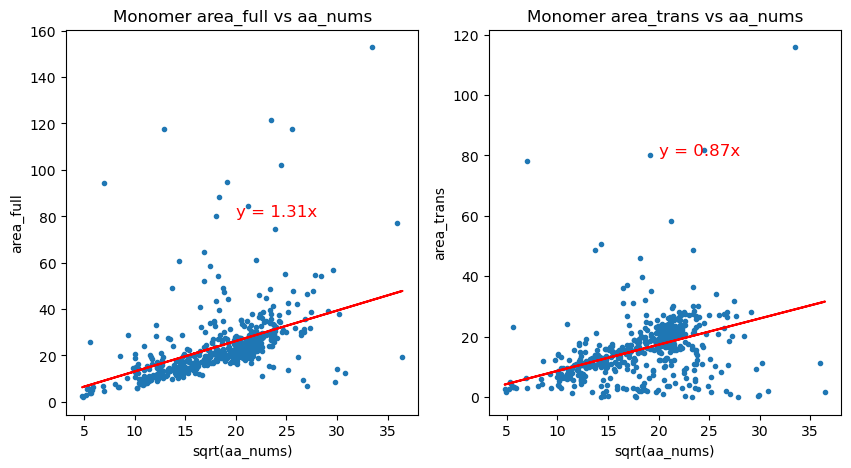

In [234]:
df_monomer = df[df.is_complex == 0]
col_selected = ["id", "seq", "selected_single_structure"] + area_col
df_monomer = df_monomer[col_selected]   
df_monomer["aa_nums"] = df_monomer["seq"].apply(lambda x: len(x))


df_monomer_clean = df_monomer[~df_monomer[area_col].isna().all(axis=1)]
df_monomer_missing = df_monomer[df_monomer[area_col].isna().all(axis=1)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
full_model = plot_area_vs_aa_nums(df_monomer_clean, "aa_nums", "area_full", "Monomer area_full vs aa_nums")
plt.subplot(1, 2, 2)
trans_model = plot_area_vs_aa_nums(df_monomer_clean, "aa_nums", "area_trans", "Monomer area_trans vs aa_nums")
df_monomer_missing.loc[:, "area_full"] = full_model.predict(np.sqrt(df_monomer_missing["aa_nums"].values.reshape(-1, 1)))
df_monomer_missing.loc[:, "area_trans"] = trans_model.predict(np.sqrt(df_monomer_missing["aa_nums"].values.reshape(-1, 1)))

# add to df_monomer
df_monomer = pd.concat([df_monomer_clean, df_monomer_missing])
df_monomer["predicted"] = df_monomer.id.apply(lambda x: 1 if x in df_monomer_missing.id.values else 0)

final_col = ["id", "area_full", "area_trans", "predicted"]
df_monomer = df_monomer[final_col]
df_monomer.to_csv("../artifacts/monomer_vs_area.csv", index=False)

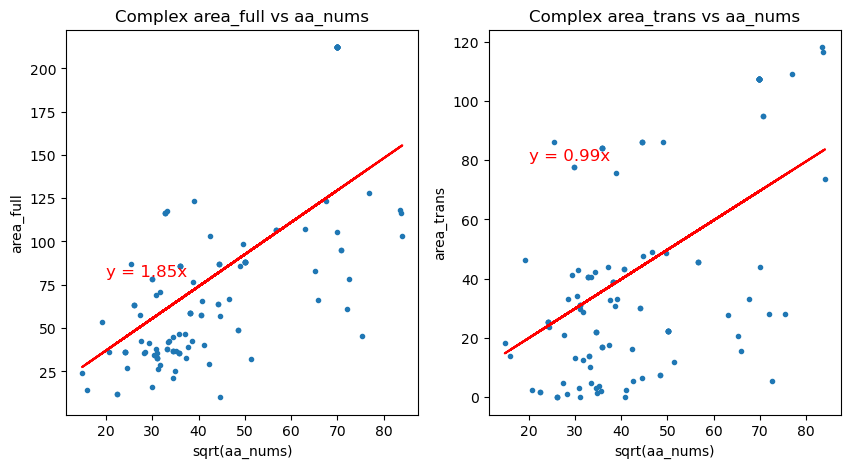

In [237]:
df_complex = df[df.is_complex == 1]
col_selected = ["complex", "selected_single_structure", "aa_nums"] + area_col
df_complex = df_complex[col_selected]
df_complex["predicted"] = df_complex["selected_single_structure"].apply(lambda x: 0 if isinstance(x, str) else 1)
df_complex
df_complex_missing = df_complex[df_complex[area_col].isna().all(axis=1)]
df_complex_clean = df_complex[~df_complex[area_col].isna().all(axis=1)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
full_model = plot_area_vs_aa_nums(df_complex_clean, "aa_nums", "area_full", "Complex area_full vs aa_nums")
plt.subplot(1, 2, 2)
trans_model = plot_area_vs_aa_nums(df_complex_clean, "aa_nums", "area_trans", "Complex area_trans vs aa_nums")

# use model to predict area in df_complex_missing
df_complex_missing.loc[:, "area_full"] = full_model.predict(np.sqrt(df_complex_missing["aa_nums"].values.reshape(-1, 1)))
df_complex_missing.loc[:, "area_trans"] = trans_model.predict(np.sqrt(df_complex_missing["aa_nums"].values.reshape(-1, 1)))

# add to df_complex
df_complex = pd.concat([df_complex_clean, df_complex_missing])
final_col = ["complex", "area_full", "area_trans", "predicted"]
df_complex = df_complex[final_col]
df_complex.to_csv("../artifacts/complex_vs_area.csv", index=False)
